In [1]:
import os
os.chdir("../../")

import numpy as np
import pandas as pd

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from tqdm import tqdm

In [2]:
target_dir = os.getcwd() + "/data/text/solomon_islands/"
filepaths = [file for file in os.listdir(target_dir) if "news" in file]

In [3]:
si_news = pd.DataFrame()
for fp in filepaths:
    source_name = fp.replace("_news.csv", "")
    path = target_dir + fp
    data = pd.read_csv(path).drop("Unnamed: 0", axis=1)
    data["source"] = source_name
    if si_news.empty:
        si_news = data
    else:
        si_news = pd.concat([si_news, data], axis=0)

si_news["date"] = pd.to_datetime(si_news["date"], format="mixed")
si_news = si_news[si_news.news.isna() != True].reset_index(drop=True)

## Vader

In [4]:
sid = SentimentIntensityAnalyzer()

score_df = pd.DataFrame()
with tqdm(total=len(si_news)) as pbar:
    for news in si_news["news"]:
        scores = sid.polarity_scores(news)
        ss_temp = pd.DataFrame(scores, columns=scores.keys(), index=[0])
        if score_df.empty:
            score_df = ss_temp
        else:
            score_df = pd.concat([score_df, ss_temp], axis=0)
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████| 43245/43245 [01:18<00:00, 554.04it/s]


In [5]:
score_df = score_df.reset_index(drop=True).rename({"compound": "vader_score"}, axis=1)
si_news = pd.concat([si_news, score_df], axis=1)
si_news.head(5)

,url,title,date,news,tag,source,neg,neu,pos,vader_score
0,https://www.sibconline.com.sb/education-minist...,EDUCATION MINISTER TELLS SINU’S FIRST GRADUAND...,2013-12-14,\nMinister for Education Dick Ha’amori has tol...,Top Headlines,sibc,0.083,0.882,0.034,-0.7910
1,https://www.sibconline.com.sb/si-national-aids...,SI National AIDS Council announces new statist...,2013-12-14,\nThe Solomon Islands National AIDS Council an...,Top Headlines,sibc,0.015,0.951,0.034,0.4404
2,https://www.sibconline.com.sb/south-guadalcana...,SOUTH GUADALCANAL RECONCILIATION LAUNCHED,2013-12-15,Tatalonga ceremony during the reconciliation\n...,Top Headlines,sibc,0.040,0.895,0.065,0.6293
3,https://www.sibconline.com.sb/lands-ps-land-de...,LANDS PS: LAND DEALINGS A GREAT CHALLENGE.,2013-12-16,"Permanent Secretary of the Ministry of Lands, ...","Land Issues, Top Headlines",sibc,0.020,0.840,0.141,0.8957
4,https://www.sibconline.com.sb/governments-mill...,GOVERNMENT’S MILLION DOLLARS ASSISTANCE HAILED.,2013-12-17,"Communities of East Malaita and Kwaio, Malaita...","Government, Politics",sibc,0.124,0.740,0.136,-0.2263


In [7]:
assert len(score_df) == len(si_news)

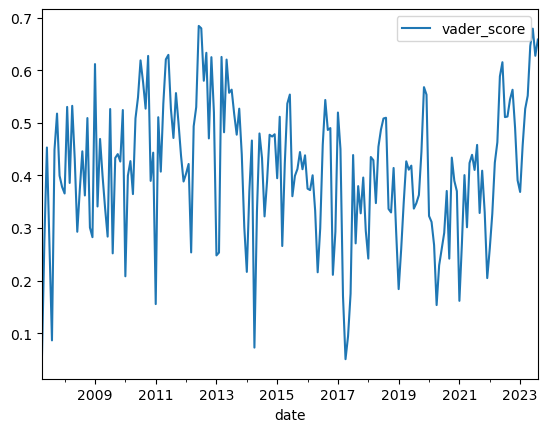

In [8]:
vader_mth = si_news.set_index("date").groupby(pd.Grouper(freq="M"))[["vader_score"]].mean().reset_index()
vader_mth.plot(x="date", y="vader_score");

In [9]:
si_sentiment_path = os.getcwd() + "/outputs/text/solomon_islands/"
if not os.path.exists(si_sentiment_path):
    os.mkdir(si_sentiment_path)
vader_mth.to_csv(si_sentiment_path + "si_sentiment_by_month.csv", encoding="utf-8")
si_news.to_csv(si_sentiment_path + "si_news_with_sentiment.csv", encoding="utf-8")